In [1]:
import os
from satpy import Scene
from satpy.writers import get_enhanced_image
import numpy as np
import xarray as xr
from pyproj import CRS
from glob import glob
import pandas as pd

In [11]:
for month, file in enumerate(modis_granule_lists):
    print(f'{month+1:02d}', file)

01 granules_2021-01-01_to_2021-01-31.csv
02 granules_2021-02-01_to_2021-02-28.csv
03 granules_2021-03-01_to_2021-03-31.csv
04 granules_2021-04-01_to_2021-04-30.csv
05 granules_2021-05-01_to_2021-05-31.csv
06 granules_2021-06-01_to_2021-06-30.csv
07 granules_2021-07-01_to_2021-07-31.csv
08 granules_2021-08-01_to_2021-08-31.csv
09 granules_2021-09-01_to_2021-09-30.csv
10 granules_2021-10-01_to_2021-10-31.csv
11 granules_2021-11-01_to_2021-11-30.csv
12 granules_2021-12-01_to_2021-12-31.csv


In [ ]:
from satpy import Scene
from pyresample.geometry import AreaDefinition
from datetime import datetime
from loguru import logger

def resample_oxford(scn):
    # oxford:  -1.2, 51.75  [lon, lat]
    area_extent = (-4, 50.0, 1, 55.0)  # Define the bounding box in lat-lon coordinates (west, south, east, north)
    resolution = 0.01  # Resolution in degrees (0.01 = ~1.1 km at the equator)
    
    # Define the target area as an AreaDefinition
    area_id = "oxford_0.1x0.1_latlon_grid"
    description = "Regular lat-lon grid covering region of interest"
    proj_dict = {"proj": "latlong", "datum": "WGS84"}
    area_def = AreaDefinition(
        area_id,
        description,
        "EPSG:4326",
        proj_dict,
        int((area_extent[2] - area_extent[0]) / resolution),
        int((area_extent[3] - area_extent[1]) / resolution),
        area_extent
    )
    
    
    scn_oxford = scn.resample(area_def)
    return scn_oxford


def get_nc_saveable_xarray(ds):
    ds = ds.drop_vars("crs")
    
    for var in ds.data_vars:
        ds[var].attrs = {}
    
    for attr in ["start_time", "end_time", "area"]:
        ds.attrs[attr] = str(ds.attrs[attr])
    return ds


# Directory for output files
output_dir = "./modis_processed/"
os.makedirs(output_dir, exist_ok=True)

modis_granule_lists = os.listdir('./modis_granules/')
modis_granule_lists = [f for f in modis_granule_lists if f.endswith('.csv')]
modis_granule_lists.sort()

for month_min1, file in enumerate(modis_granule_lists):
    month = f'{month_min1+1:02d}'
    logger.info(f'starting remapping month {month}')
    os.makedirs(os.path.join(output_dir, month), exist_ok=True)
    os.makedirs(os.path.join(output_dir, month, 'netcdf'), exist_ok=True)
    os.makedirs(os.path.join(output_dir, month, 'numpy'), exist_ok=True)
    
    modis_files = pd.read_csv(f'./modis_granules/{file}')
    
    # processed_day = None
    for index, row in modis_files.iterrows():
        if index<1: continue
        file_path = os.path.join('/neodc/modis/data/MOD021KM/collection61', row['path'])
    
        file_day = row['day']
    
        # open the scene
        scn = Scene(reader='modis_l1b', filenames=[file_path])
    
        # load channels for project (1,2,3,5)
        scn.load(['1', '2', '3', '5'])  # Adjust channel names as required by your analysis
        
        # resample the scene to the 0.01x0.01 grid over oxford
        oxford_scn = resample_oxford(scn)
        
        # save as netcdf
        ds = oxford_scn.to_xarray_dataset()
        ds = get_nc_saveable_xarray(ds)
        base_name = os.path.basename(file_path).replace('.hdf', '')
        output_file_path = os.path.join(output_dir, month, 'netcdf', f"{base_name}_oxford_remap.nc")
        ds.to_netcdf(output_file_path)
    
        # save as compressed numpy
        band_order = ['1', '2', '3', '5']
        band_list = [ds[band].values for band in band_order]
        band_list += [np.tile(ds['y'].values, (ds['x'].shape[0],1)).T, np.tile(ds['x'].values, (ds['y'].shape[0],1))]
        
        band_array = np.stack(band_list, axis=-1)
    
        output_file_path = os.path.join(output_dir, month, 'numpy', f"{base_name}_oxford_remap.npz")
        np.savez_compressed(output_file_path, data=band_array)
        ds.close()
    
        logger.info(f"saved {base_name}")


2024-11-11 18:20:11.254 | INFO     | __main__:<module>:51 - starting remapping month 01
2024-11-11 18:20:18.703 | INFO     | __main__:<module>:92 - saved MOD021KM.A2021002.1120.061.2021002190459
2024-11-11 18:20:26.042 | INFO     | __main__:<module>:92 - saved MOD021KM.A2021003.1025.061.2021004151042
2024-11-11 18:20:33.760 | INFO     | __main__:<module>:92 - saved MOD021KM.A2021004.1105.061.2021004190923
2024-11-11 18:20:40.389 | INFO     | __main__:<module>:92 - saved MOD021KM.A2021005.1010.061.2021008160834
2024-11-11 18:20:47.284 | INFO     | __main__:<module>:92 - saved MOD021KM.A2021006.1055.061.2021006191344
2024-11-11 18:20:54.341 | INFO     | __main__:<module>:92 - saved MOD021KM.A2021007.1000.061.2021007191343
2024-11-11 18:21:01.978 | INFO     | __main__:<module>:92 - saved MOD021KM.A2021008.1040.061.2021008194750
2024-11-11 18:21:09.491 | INFO     | __main__:<module>:92 - saved MOD021KM.A2021008.1045.061.2021008194210
2024-11-11 18:21:17.386 | INFO     | __main__:<module>:9

In [122]:
import xarray as xr
import numpy as np

# bands 1,2,3,5 and latitude y and longitude x
# band_order = ['1', '2', '3', '5']

# band_list = [ds[band].values for band in band_order]

# data_array = np.stack([ds[band].values for band in band_order], axis=-1)
# data_array.shape


def resample_test(scn):
    # oxford:  -1.2, 51.75  [lon, lat]
    area_extent = (-8, 50.0, 1, 55.0)  # Define the bounding box in lat-lon coordinates (west, south, east, north)
    resolution = 0.01  # Resolution in degrees (0.01 = ~1.1 km at the equator)
    
    # Define the target area as an AreaDefinition
    area_id = "oxford_0.1x0.1_latlon_grid"
    description = "Regular lat-lon grid covering region of interest"
    proj_dict = {"proj": "latlong", "datum": "WGS84"}
    area_def = AreaDefinition(
        area_id,
        description,
        "EPSG:4326",
        proj_dict,
        int((area_extent[2] - area_extent[0]) / resolution),
        int((area_extent[3] - area_extent[1]) / resolution),
        area_extent
    )
    
    
    scn_oxford = scn.resample(area_def)
    return scn_oxford



band_order = ['1', '2', '3', '5']

band_list = [ds[band].values for band in band_order]
band_list += [np.tile(ds['y'].values, (ds['x'].shape[0],1)).T, np.tile(ds['x'].values, (ds['y'].shape[0],1))]

band_array = np.stack(band_list, axis=-1)
band_array.shape

(500, 900, 6)

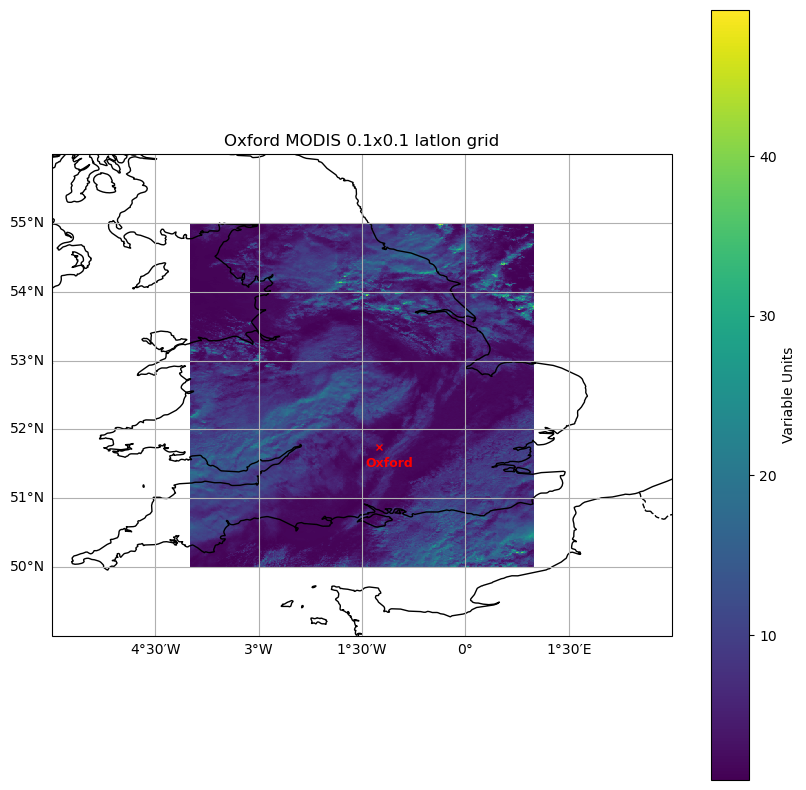

In [97]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

data = oxford_scn['1']

# Define the map projection (Plate Carrée for latitude/longitude)
projection = ccrs.PlateCarree()

# Create a figure and an axis with the projection
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': projection})

# Plot the data using the `plot()` method for xarray DataArray, with coastlines and UK extent
data.plot(ax=ax, transform=projection, cmap='viridis', cbar_kwargs={'label': 'Variable Units'})

# Add coastlines, borders, and other features
ax.coastlines(resolution='10m', color='black', linewidth=1)
ax.add_feature(cfeature.BORDERS.with_scale('10m'), linestyle='--')

# Set the extent to cover the whole UK (rough bounding box for the UK)
ax.set_extent([-6, 3, 49, 56], crs=projection)

# Add gridlines for reference
gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
gl.top_labels = False
gl.right_labels = False


# Add a Red Cross for Oxford's location
oxford_lon, oxford_lat = -1.2577, 51.7520  # Longitude and latitude for Oxford
ax.plot(oxford_lon, oxford_lat, marker='x', color='red', markersize=5, label="Oxford", transform=projection)
ax.text(oxford_lon-0.2, oxford_lat-0.3, 'Oxford', color='red', weight='bold', fontsize=9)

# Show the plot
plt.title("Oxford MODIS 0.1x0.1 latlon grid")
plt.show()